In [77]:
#Import Libraries

# Core
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Geospatial
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)


In [78]:
df_combined = pd.read_csv('../data/combined.csv')

In [79]:
df_combined.describe()

,precipitation,max_temp,min_temp,avg_wind_speed,temp_range,wind_temp_ratio,lagged_precipitation,lagged_avg_wind_speed,month,fire_longitude,fire_latitude,fire_acres_burned,bright_t31,frp,brightness
count,2817.000000,2817.000000,2817.000000,2814.000000,2817.000000,2814.000000,2817.000000,2817.000000,2817.000000,2.817000e+03,2817.000000,2.764000e+03,2195.000000,2195.000000,2195.000000
mean,0.002769,75.318779,62.455094,7.632093,12.863685,0.102280,0.014590,7.671894,7.237842,-4.230568e+05,38.982392,4.293149e+03,298.191856,93.813765,330.998577
std,0.056411,6.341202,4.839783,1.400887,5.161444,0.021867,0.114598,0.909598,1.832729,2.244758e+07,102.849071,3.528447e+04,5.352055,103.998736,11.949924
min,0.000000,59.000000,41.000000,2.460000,3.000000,0.029286,0.000000,3.578571,1.000000,-1.191415e+09,-120.258000,0.000000e+00,267.300000,5.600000,305.500000
25%,0.000000,71.000000,60.000000,6.710000,10.000000,0.088904,0.000000,7.191429,6.000000,-1.216869e+02,34.624120,3.000000e+01,295.758755,44.033746,324.191803
50%,0.000000,74.000000,63.000000,7.610000,11.000000,0.102410,0.000000,7.765714,7.000000,-1.204735e+02,37.118582,8.500000e+01,298.075419,68.709091,329.412462
75%,0.000000,78.000000,66.000000,8.500000,15.000000,0.114865,0.000000,8.181429,8.000000,-1.184733e+02,39.088050,3.492500e+02,300.521356,110.307675,335.596089
max,2.030000,104.000000,77.000000,17.670000,37.000000,0.230615,2.450000,11.505714,12.000000,1.189082e+02,5487.000000,1.032648e+06,333.400000,2945.600000,447.800000


In [80]:
df_combined.shape

(2817, 19)

## Geographic Validation & Coordinate Cleaning

### California Coordinate Bounds
To ensure data integrity, we validate that all coordinates fall within California:

- **Latitude:** 32.5° to 42.0°  
- **Longitude:** –124.5° to –114.0°

### Issues Detected

#### fire_latitude
- **Min:** `-120.26`  
- **Max:** `5487.00`  
- **Invalid entries:** 16 rows

#### fire_longitude
- **Min:** `-1,191,414,610.0`  
- **Max:** `118.91`  
- **Invalid entries:** 14 rows

### Common Problems

| Type            | Example                        |
|------------------|--------------------------------|
| Out-of-range     | Latitude `5487.0`, Longitude `118.91` |
| Corrupted        | `-1191414610.0` (likely malformed)     |
| Incorrect sign   | Positive longitudes should be negative |

### Action Plan

1. **Detect**: Identify invalid coordinates using bounds.
2. **Cross-check**: Use `fire_county` to infer location.
3. **Correct or drop**:  
   - Replace with county centroid if recoverable  
   - Drop if not fixable  
4. **Log outcomes**: Track how many rows were fixed vs. removed.


In [82]:
# Identify invalid lat/lon
invalid_lat = (df_combined['fire_latitude'] < 32.5) | (df_combined['fire_latitude'] > 42.0)
invalid_lon = (df_combined['fire_longitude'] < -124.5) | (df_combined['fire_longitude'] > -114.0)
invalid_location_rows = df_combined[invalid_lat | invalid_lon]

# Count how many have a non-null county name and list sample counties
valid_county_in_invalid_location = invalid_location_rows['fire_county'].notnull().sum()
sample_counties = invalid_location_rows['fire_county'].dropna().unique()

valid_county_in_invalid_location, sample_counties

(24,
 array(['San Diego', 'Solano', 'Calaveras', 'Siskiyou', 'Shasta', 'Madera',
        'Mariposa', 'Lake', 'Butte', 'Trinity', 'San Benito', 'Kern',
        'Riverside', 'San Luis Obispo', 'State of Oregon', 'Lassen',
        'Contra Costa', 'Mendocino', 'Los Angeles', 'Alameda, Humboldt'],
       dtype=object))

## County Name Validation and Cleanup

### Objective
Ensure all values in `fire_county` or `clean_county` are valid California counties for accurate geographic joins and county-level analysis.

### Key Findings

#### 1. `State of Oregon` — Out-of-State
- **Problem**: Not part of California.
- **Action**: Exclude from analysis.

#### 2. `Alameda, Humboldt` — Combined Entry
- **Problem**: Two valid counties merged.
- **Action**:  
  - Split into separate rows, or  
  - Assign based on coordinates if only one location is appropriate.

#### 3. All Other Entries — Valid
- Confirmed using [SimpleMaps US Counties](https://simplemaps.com/data/us-counties).
- Safe for use in spatial joins and aggregation.

### Summary

| Type         | Example               | Action     |
|--------------|------------------------|------------|
| Out-of-state | `State of Oregon`      | Exclude    |
| Malformed    | `Alameda, Humboldt`    | Resolve    |
| Valid        | `Los Angeles`          | Use as-is  |

Standardizing county names ensures clean joins and reliable spatial analysis.


In [84]:
# Load the California counties GeoJSON
county_gdf = gpd.read_file("../data/California_Counties.geojson")
county_gdf = county_gdf.explode(index_parts=False).reset_index(drop=True)
county_gdf = county_gdf[['NAME', 'geometry']].rename(columns={'NAME': 'county_name'})

# Convert fire data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_combined['fire_longitude'], df_combined['fire_latitude'])]
fire_gdf = gpd.GeoDataFrame(df_combined, geometry=geometry, crs="EPSG:4326")

# Spatial join: assign county name from official county boundaries
fire_with_county = gpd.sjoin(fire_gdf, county_gdf, how='left', predicate='within')

# Assign joined county name to 'clean_county'
fire_with_county['clean_county'] = fire_with_county['county_name']
fire_with_county.drop(columns=['geometry', 'index_right', 'county_name'], inplace=True)

# Save back to df_combined
df_combined = pd.DataFrame(fire_with_county)

# Identify out-of-range coordinates for California
invalid_lat = (df_combined['fire_latitude'] < 32.5) | (df_combined['fire_latitude'] > 42.0)
invalid_lon = (df_combined['fire_longitude'] < -124.5) | (df_combined['fire_longitude'] > -114.0)
invalid_coords = invalid_lat | invalid_lon

# Drop rows with invalid coordinates
df_combined = df_combined[~invalid_coords]

# Drop the original fire_county column if it exists
if 'fire_county' in df_combined.columns:
    df_combined.drop(columns=['fire_county'], inplace=True)

# Final cleaned DataFrame
df_cleaned_final = df_combined.copy()


In [85]:
df_cleaned_final.head()

,fire_name,fire_dateonly_created,precipitation,max_temp,min_temp,avg_wind_speed,temp_range,wind_temp_ratio,lagged_precipitation,lagged_avg_wind_speed,month,season,fire_longitude,fire_latitude,fire_acres_burned,bright_t31,frp,brightness,clean_county
0,Bridge Fire,2017-10-31,0.0,69.0,63.0,6.04,6.0,0.087536,0.00,6.391429,10,Fall,-122.309000,40.774000,37.0,289.939315,28.226986,315.575205,Shasta County
2,River Fire,2013-02-24,0.0,65.0,46.0,7.61,19.0,0.117077,0.13,8.885714,2,Winter,-118.016510,36.602575,407.0,286.600000,67.900000,321.200000,Inyo County
3,Fawnskin Fire,2013-04-20,0.0,78.0,55.0,5.82,23.0,0.074615,0.06,9.332857,4,Spring,-116.941311,34.288877,30.0,294.734078,29.368715,316.384916,San Bernardino County
4,Gold Fire,2013-04-30,0.0,67.0,59.0,7.61,8.0,0.113582,0.00,7.062857,4,Spring,-119.635004,37.116295,274.0,296.064780,33.913836,317.152201,Madera County
5,Panther Fire,2013-05-01,0.0,71.0,61.0,7.61,10.0,0.107183,0.00,7.382857,5,Spring,-121.595555,40.190062,6896.0,313.700000,321.400000,409.300000,Tehama County


In [86]:
df_cleaned_final.isnull().sum().sort_values(ascending=False)

brightness               620
frp                      620
bright_t31               620
fire_acres_burned         52
clean_county              11
avg_wind_speed             3
wind_temp_ratio            3
season                     0
fire_latitude              0
fire_longitude             0
fire_name                  0
month                      0
fire_dateonly_created      0
lagged_precipitation       0
temp_range                 0
min_temp                   0
max_temp                   0
precipitation              0
lagged_avg_wind_speed      0
dtype: int64

##  Missing Data Analysis

Understanding missing values is critical for determining the reliability and completeness of your dataset. Below is a breakdown of missing values across key columns, along with potential reasons and classifications based on missingness mechanisms.

---

###  Missing Values Summary

| Column                         | Missing Values | Notes                                                        |
|--------------------------------|----------------|--------------------------------------------------------------|
| `brightness`, `frp`, `bright_t31` | 621            | MODIS satellite data missing for some fires or times         |
| `fire_date_extinguished`       | 617            | May be missing for **ongoing** or **small** fires            |
| `fire_acres_burned`            | 52             | Possibly unmeasured for **early, short-lived, or small** fires |
| `fire_county`                  | 9              | County/location parsing failed or was incomplete             |
| `avg_wind_speed`               | 3              | Likely gaps in **weather station** data                      |
| `wind_temp_ratio`             | 3              | Derived column; missing because base weather features are missing |

---

###  Understanding the Type of Missingness

| Column                         | Missingness Type     | Reasoning                                                                                      |
|--------------------------------|----------------------|------------------------------------------------------------------------------------------------|
| `brightness`, `frp`, `bright_t31` | **MAR (Missing At Random)** | Missingness depends on observable variables like time, cloud cover, or satellite passes, not on the values themselves. |
| `fire_date_extinguished`       | **NMAR (Not Missing At Random)** | The absence of this value often **depends on the fire not being extinguished**, an unobserved condition. |
| `fire_acres_burned`            | **NMAR or MAR**       | Likely missing due to severity, fire duration, or lack of measurement. Missingness may depend on unrecorded fire characteristics. |
| `fire_county`                  | **MAR**              | Missing likely due to parsing or record quality; depends on observable metadata reliability.   |
| `avg_wind_speed`, `wind_temp_ratio` | **MAR**              | Missing due to **external weather data gaps**, often tied to date or location rather than the variable itself. |

---

###  Implications for Analysis

- **MAR values** can often be imputed using models based on other features (e.g., date, location, temperature).
- **NMAR values** may bias results if not addressed, especially for variables like `fire_acres_burned` and `fire_date_extinguished`, where the absence of data could be informative.
- Columns like `fire_county` may benefit from **spatial joins** or centroid inference to reduce missingness.
- Low-frequency missing values (like in wind features) may be dropped or forward/backfilled if appropriate.

---

Proper handling of missing data ensures robustness and integrity in downstream modeling, particularly for spatial and time-series wildfire prediction tasks.


In [88]:
# Check correlation between brightness, frp, and bright_t31
correlation_matrix =  df_cleaned_final[['brightness', 'frp', 'bright_t31']].corr()
correlation_matrix

,brightness,frp,bright_t31
brightness,1.000000,0.721462,0.666363
frp,0.721462,1.000000,0.326334
bright_t31,0.666363,0.326334,1.000000


###  Correlation Insight: Imputation Strategy

An exploratory correlation analysis revealed that:

  - `brightness` is **strongly correlated** with both:
  - `frp` (Fire Radiative Power)
  - `bright_t31` (Thermal infrared brightness temperature)

This makes `brightness` a **strong candidate** for **iterative imputation**. By leveraging its high correlation with the other two variables, we can accurately estimate missing values in `frp` or `bright_t31` (and vice versa) using models such as:
- IterativeImputer (scikit-learn)

In [90]:
# Remove rows where fire size is 0 or missing
df_cleaned_final = df_cleaned_final[df_cleaned_final['fire_acres_burned'].replace(0, np.nan).notnull()]

# Iterative imputation for satellite columns
iterative_imputer = IterativeImputer(random_state=42)
satellite_cols = ['brightness', 'frp', 'bright_t31']
df_cleaned_final[satellite_cols] = iterative_imputer.fit_transform(df_cleaned_final[satellite_cols])

# Median imputation for wind-related columns
for col in ['avg_wind_speed', 'wind_temp_ratio']:
    df_cleaned_final[col] = df_cleaned_final[col].fillna(df_cleaned_final[col].median())

df_combined = df_combined[df_combined['clean_county'].notnull()]

In [91]:
#convert to datetime
df_cleaned_final['fire_dateonly_created'] = pd.to_datetime(df_cleaned_final['fire_dateonly_created'])

##  Feature Classification & Description

To effectively model wildfire behavior and understand contributing factors, features in the dataset have been grouped into five functional categories. Each group represents a distinct aspect of the data: temporal trends, environmental conditions, fire behavior, spatial location, and engineered relationships.

---

###  1. Temporal Features

| Feature               | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `fire_dateonly_created` | The date the fire was reported or created, excluding timestamp              |
| `month`              | Extracted from the fire date; helps identify seasonal patterns               |
| `season`             | Categorical label for meteorological season (Winter, Spring, etc.)           |

These features help capture **time-based trends** such as fire frequency during dry months or seasonal fire behavior.

---

###  2. Weather-Related Features

| Feature                 | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| `precipitation`         | Precipitation on the day of the fire (in mm or inches)                     |
| `max_temp`              | Maximum daily temperature at the fire’s location                           |
| `min_temp`              | Minimum daily temperature at the fire’s location                           |
| `avg_wind_speed`        | Average wind speed on the fire day                                         |
| `temp_range`            | Difference between max and min temperature                                 |
| `lagged_precipitation`  | Precipitation from the **previous day** (lag-1), to model fuel moisture    |
| `lagged_avg_wind_speed` | Wind speed from the **previous day**, may influence fire spread speed      |

These variables capture **environmental conditions** that influence fire ignition and spread potential.

---

###  3. Fire Behavior Features

| Feature     | Description                                               |
|-------------|-----------------------------------------------------------|
| `brightness`| Measured radiance (visible/IR) at the fire center         |
| `bright_t31`| Thermal infrared brightness temperature (band 31)         |
| `frp`       | Fire Radiative Power — estimates the energy released      |

These satellite-derived metrics reflect **fire intensity, size, and energy**, and are key indicators for fire classification.

---

###  4. Engineered Features

| Feature           | Description                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `wind_temp_ratio` | Custom ratio derived from wind speed and temperature. Proxy for spread rate or burn efficiency. |

This feature is derived to introduce **nonlinear interactions** between wind and temperature, potentially improving predictive power.

---

###  5. Spatial Features

| Feature         | Description                                                      |
|-----------------|------------------------------------------------------------------|
| `fire_latitude` | Latitude of fire origin                                          |
| `fire_longitude`| Longitude of fire origin                                         |
| `clean_county`  | County where the fire occurred, derived using spatial join logic |

These features enable **geospatial modeling** and allow for clustering, mapping, and county-level analysis.

---

###  Summary

Categorizing features not only improves interpretability but also guides:
- Feature selection for modeling,
- Imputation strategies (e.g., temporal vs. spatial interpolation),
- Visualization and EDA design.

Each group provides a lens through which wildfire behavior can be understood and predicted more effectively.


In [93]:
df_cleaned_final.to_csv('../data/cleaned.csv', index=False)

In [94]:
df_cleaned_final = pd.read_csv('../data/cleaned.csv',parse_dates=['fire_dateonly_created'])

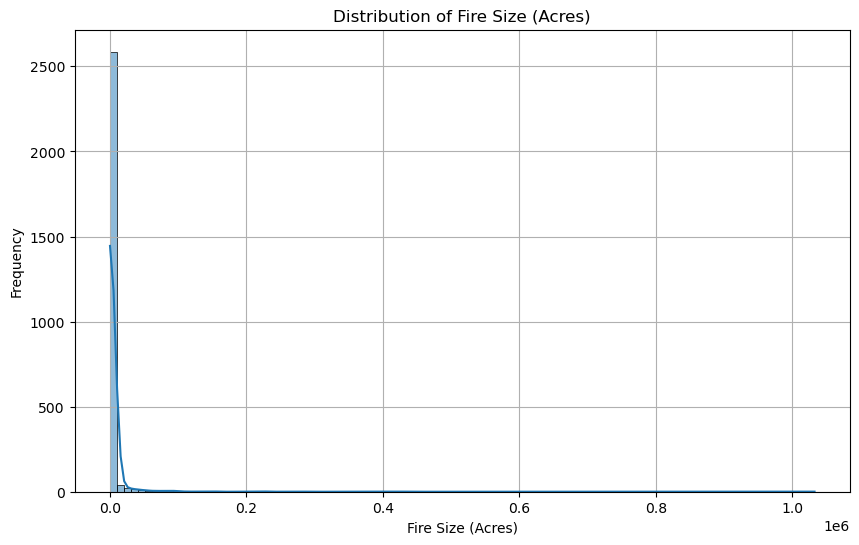

In [95]:
# Step 1: Plot the distribution of fire size (fire_acres_burned)
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_final['fire_acres_burned'], bins=100, kde=True)
plt.title("Distribution of Fire Size (Acres)")
plt.xlabel("Fire Size (Acres)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

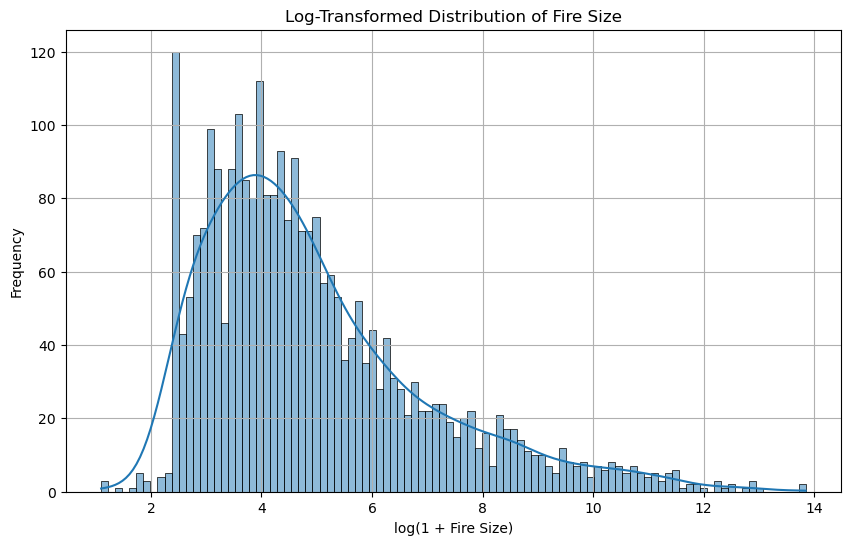

In [96]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_cleaned_final['fire_acres_burned']), bins=100, kde=True)
plt.title("Log-Transformed Distribution of Fire Size")
plt.xlabel("log(1 + Fire Size)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

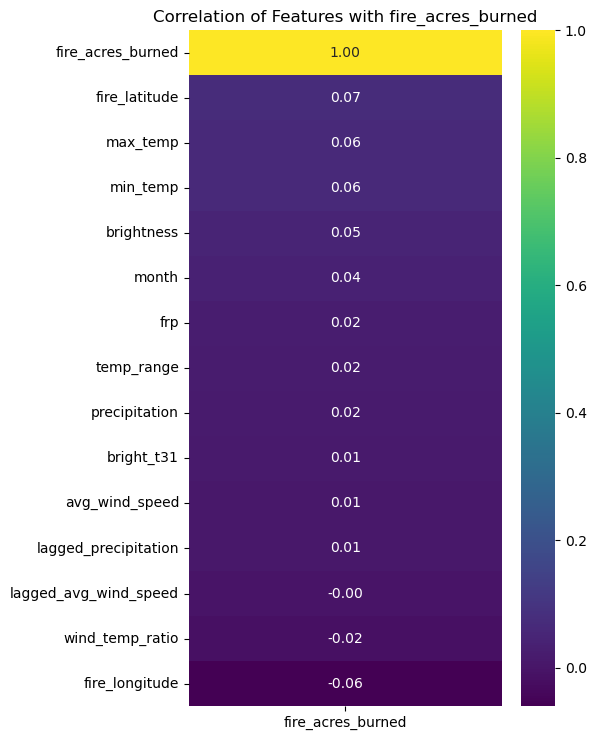

In [97]:
# Calculate correlations
corr = df_cleaned_final.select_dtypes(include=['float64', 'int64']).corr()

# Get only the correlations of fire_acres_burned with other features
fire_corr = corr[['fire_acres_burned']].sort_values(by='fire_acres_burned', ascending=False)

# Plot heatmap
plt.figure(figsize=(6, len(fire_corr) * 0.5))
sns.heatmap(fire_corr, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Correlation of Features with fire_acres_burned")
plt.tight_layout()
plt.show()

###  Low Correlation Across All Features

- Most features have a **correlation coefficient below 0.1**, meaning there is **no strong linear relationship** between them and the target variable `fire_acres_burned`.
- This suggests that **fire size may depend on nonlinear relationships**, **interactions**, or **unobserved variables** such as fuel type or topography.


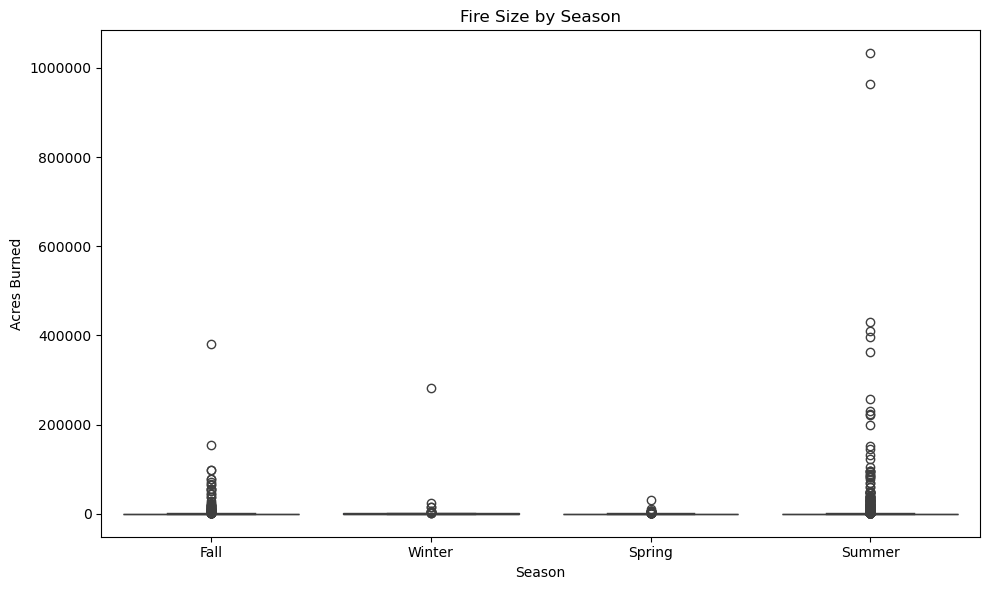

In [99]:
# Plot 3: Boxplot - Season vs Fire Size
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='fire_acres_burned', data=df_cleaned_final)
plt.title('Fire Size by Season')
plt.xlabel('Season')
plt.ylabel('Acres Burned')

# Disable scientific notation on y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

- **Summer is the most dangerous fire season** in terms of scale and frequency of large wildfires.
- **Winter and Spring are relatively safer**, with fewer and smaller incidents.
- These seasonal insights are valuable for **fire preparedness planning**, resource allocation, and modeling fire risk over time.

> The presence of extreme outliers suggests the need for log-scaling or robust modeling approaches to avoid skewed results in predictive tasks.

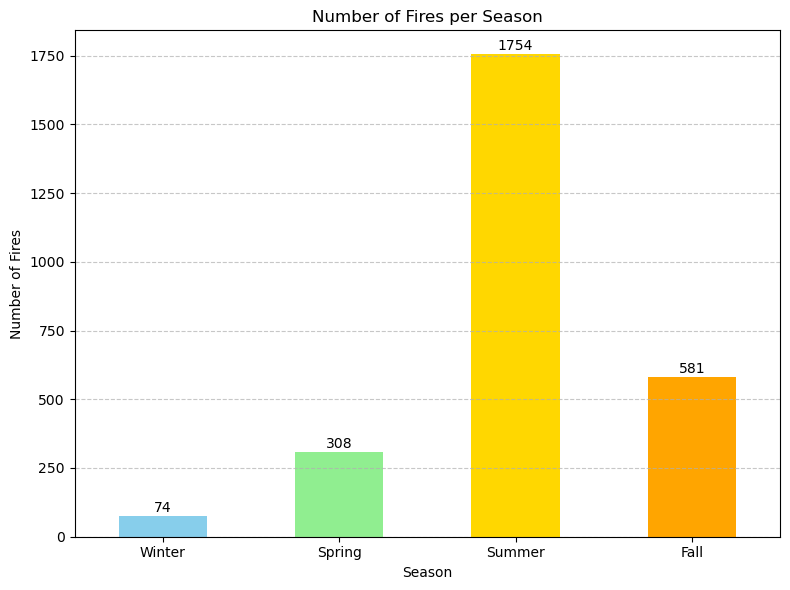

In [101]:
# Recount fires per season
season_counts = df_cleaned_final['season'].value_counts().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Plotting with custom colors for each season
colors = ['skyblue', 'lightgreen', 'gold', 'orange']  # colors for Winter, Spring, Summer, Fall

# Plotting the bar chart with value labels
plt.figure(figsize=(8, 6))
bars = season_counts.plot(kind='bar', color=colors)
plt.title("Number of Fires per Season")
plt.xlabel("Season")
plt.ylabel("Number of Fires")
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on each bar
for idx, value in enumerate(season_counts):
    plt.text(idx, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

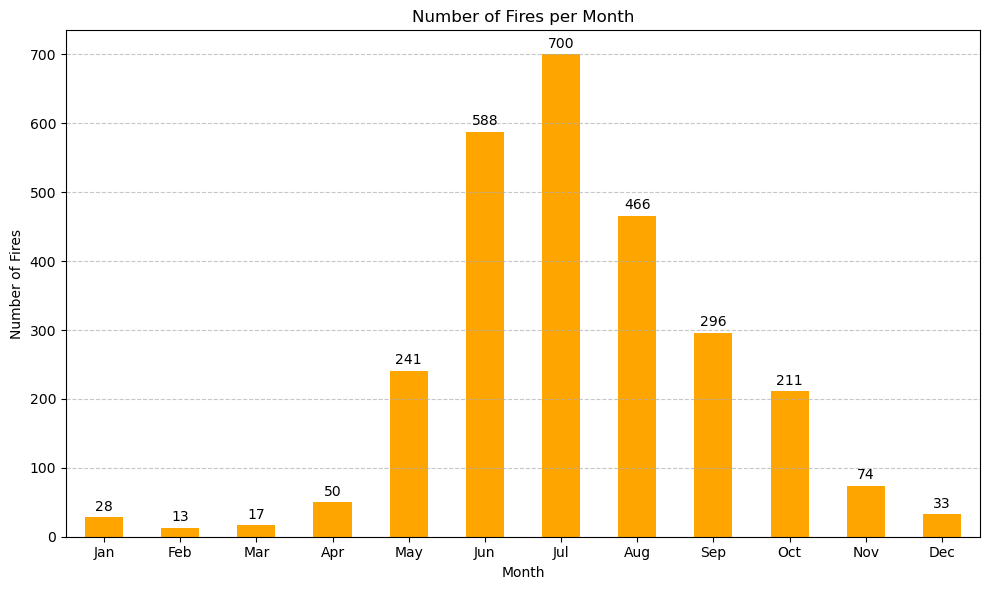

In [102]:
# Compute fire counts by month 
monthly_fire_counts = pd.to_datetime(df_cleaned_final['fire_dateonly_created']).dt.month.value_counts().sort_index()

# Plotting with value labels
plt.figure(figsize=(10, 6))
bars = monthly_fire_counts.plot(kind='bar', color='orange')
plt.title("Number of Fires per Month")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for idx, value in enumerate(monthly_fire_counts):
    plt.text(idx, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

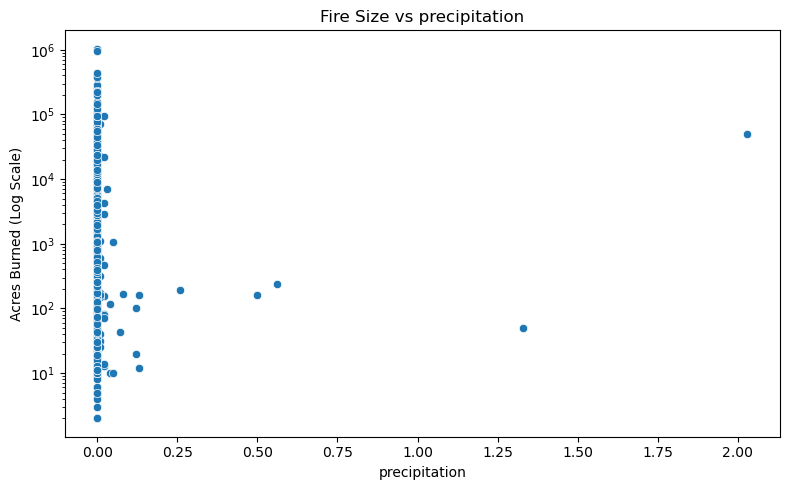

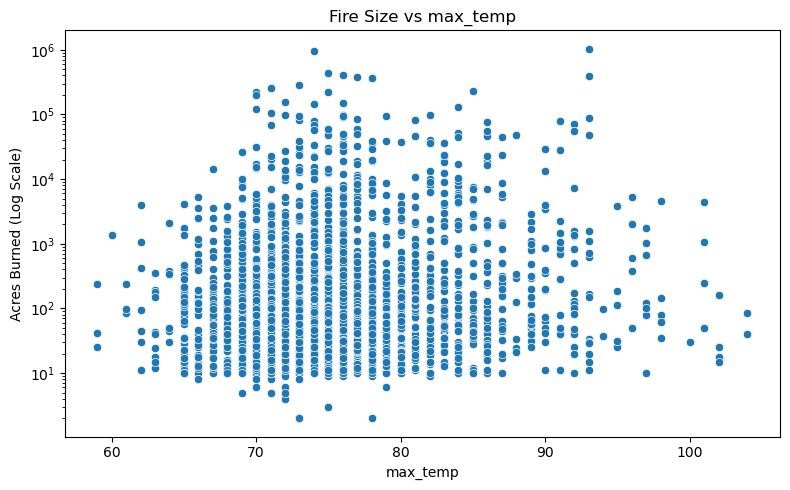

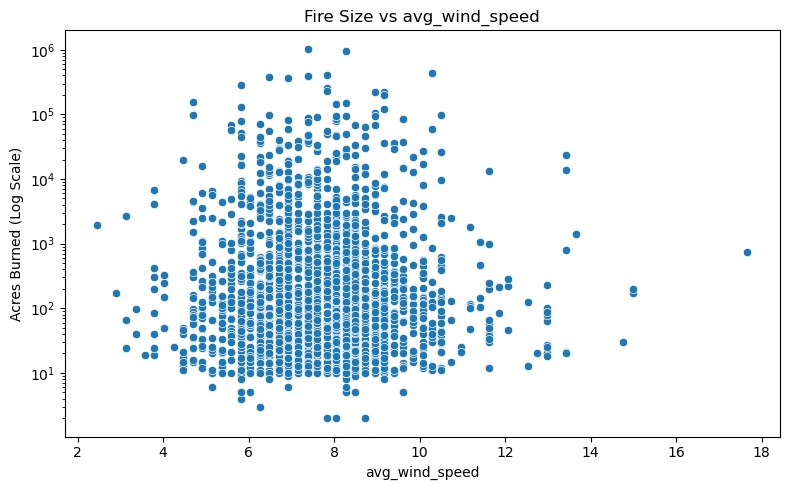

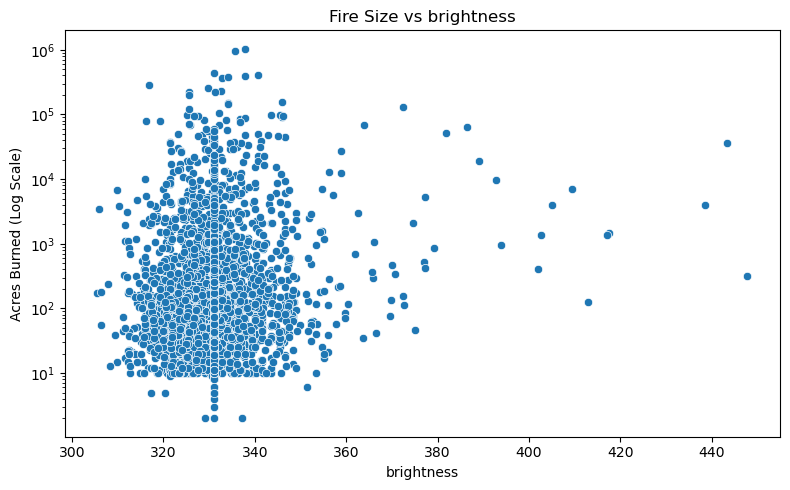

In [103]:
features = ['precipitation', 'max_temp', 'avg_wind_speed', 'brightness']
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=feature, y='fire_acres_burned', data=df_cleaned_final)

    plt.yscale('log')  # Log-scale the y-axis
    plt.title(f'Fire Size vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Acres Burned (Log Scale)')

    plt.tight_layout()
    plt.show()

### Precipitation
- Strong negative correlation: large fires occur with little to no rain.

### Max Temperature
- Slight positive trend: larger fires more likely in warmer conditions (75°F–95°F).

### Avg Wind Speed
- No clear pattern; most fires in 6–10 mph range.

### Brightness
- Loose association with higher values (320–360), but correlation is weak.

### Summary
- **Precipitation** has the strongest influence.
- Other features show weak or nonlinear patterns, suggesting interaction effects or nonlinear models may help.


In [105]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df_cleaned_final['precipitation'], np.log1p(df_cleaned_final["fire_acres_burned"]))

print(f"Pearson correlation coefficient: {corr:.4f}")

Pearson correlation coefficient: 0.0394


# Spatio-Temporal Analysis

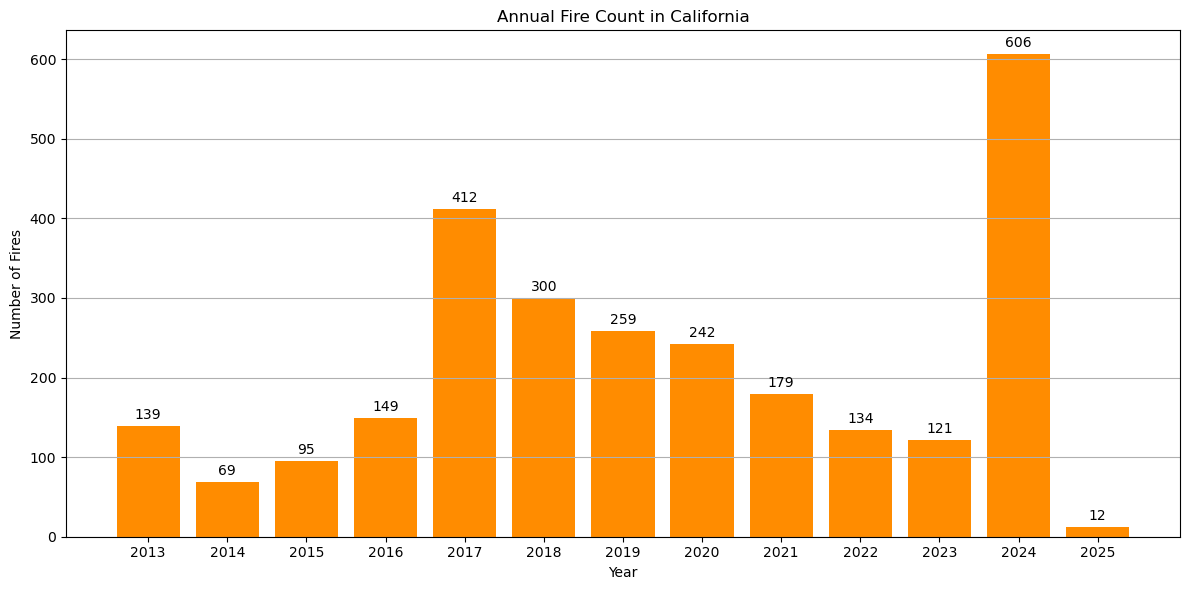

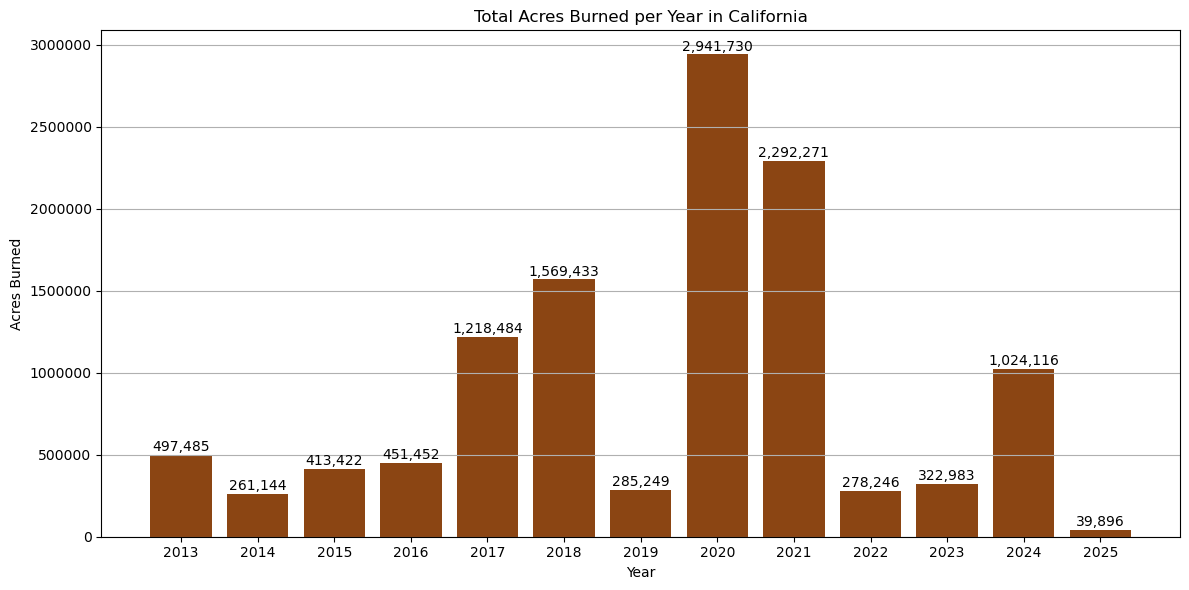

In [107]:
# Extract year from creation date
df_cleaned_final['year'] = df_cleaned_final['fire_dateonly_created'].dt.year

# Group by year to get fire count and total acres burned
annual_stats = df_cleaned_final.groupby('year').agg(
    fire_count=('fire_name', 'count'),
    total_acres_burned=('fire_acres_burned', 'sum')
).reset_index()

# Bar plot for fire count with all years on x-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats['year'], annual_stats['fire_count'], color='darkorange')
plt.title('Annual Fire Count in California')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y')
plt.xticks(annual_stats['year'])  # Show all years on x-axis
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

# Bar plot for total acres burned with all years on x-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats['year'], annual_stats['total_acres_burned'], color='saddlebrown')
plt.title('Total Acres Burned per Year in California')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.grid(axis='y')
plt.xticks(annual_stats['year'])  # Show all years on x-axis
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f"{int(yval):,}", ha='center', va='bottom')

plt.show()

## Annual Trends in California Wildfires

### 1. Number of Fires
- Peaked in **2017**, dipped after **2018**, with a spike in **2024** (possibly due to reporting).
- General decline in fire counts through **2023**.

### 2. Total Acres Burned
- **2020** saw the most damage: **2.9M+ acres**, despite fewer fires.
- High-damage years: **2018**, **2020**, **2021**.
- Post-2021 decline may reflect better containment or weather.

### Key Takeaways
- **More fires ≠ more destruction** (e.g., 2020).
- Focus should be on **fire scale**, not just count.
- Planning must account for **megafires**—low frequency, high impact.

<Figure size 1200x1000 with 0 Axes>

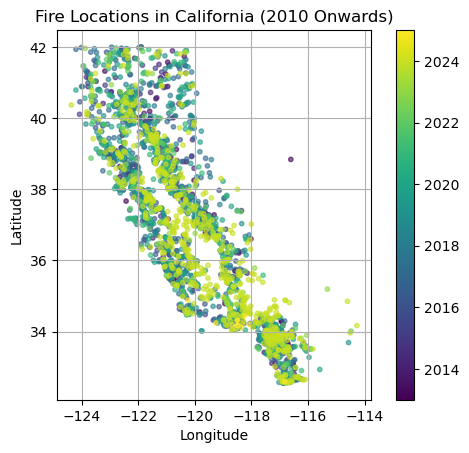

In [109]:
# Filter data from 2010 and drop rows with missing coordinates
df_map = df_cleaned_final[df_cleaned_final['year'] >= 2010].copy()
df_map = df_map.dropna(subset=['fire_latitude', 'fire_longitude'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map['fire_longitude'], df_map['fire_latitude']),
    crs="EPSG:4326"
)

# Plot fire locations colored by year
plt.figure(figsize=(12, 10));
gdf.plot(column='year', cmap='viridis', legend=True, markersize=10, alpha=0.6)
plt.title('Fire Locations in California (2010 Onwards)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show();

### Key Observations

- **Fires are widely distributed across the state**, but most frequently occur along the **Sierra Nevada foothills**, **northern forests**, and **southern inland valleys**.
- **Dense clusters** appear in:
  - **Northern California** (around latitude 40°–42°)
  - **Central Sierra Nevada** (lat ~36°–39°, long ~–120°)
  - **Southern California** (lat ~33°–35°, long ~–118° to –116°)
- The **yellow-to-green color concentration** in recent years suggests continued fire activity across the same vulnerable zones.

---

### Temporal Insight

- There is **no major geographic shift** in where fires occur over time — high-risk zones remain consistently active.
- **Recent years (2020–2024)** show **denser coverage**, which may reflect increased wildfire activity, improved satellite detection, or better reporting.


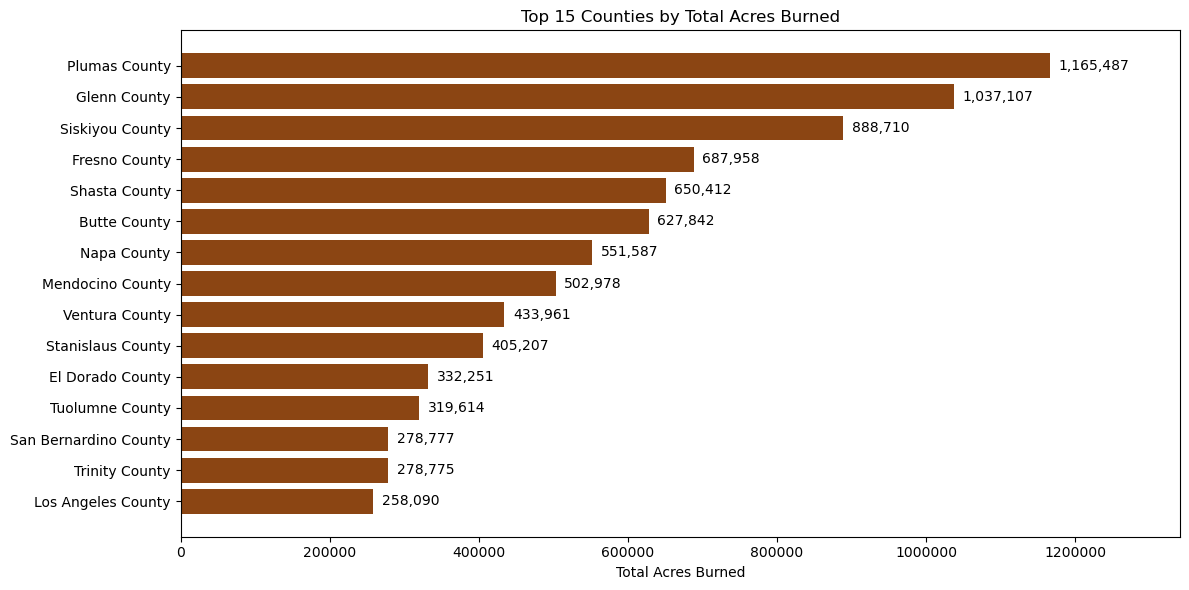

In [111]:
# Group by county to compute total and average acres burned
county_fire_stats = df_cleaned_final.groupby('clean_county').agg(
    total_acres_burned=('fire_acres_burned', 'sum'),
    average_acres_burned=('fire_acres_burned', 'mean'),
    fire_count=('fire_name', 'count')
).reset_index()

# Sort by total acres burned
top_counties = county_fire_stats.sort_values(by='total_acres_burned', ascending=False).head(15)

# Plotting with value labels on bars
plt.figure(figsize=(12, 6))
bars = plt.barh(top_counties['clean_county'], top_counties['total_acres_burned'], color='saddlebrown')
plt.xlabel('Total Acres Burned')
plt.title('Top 15 Counties by Total Acres Burned')
plt.gca().invert_yaxis()
plt.ticklabel_format(style='plain', axis='x')

# Set x-axis limit to add padding on the right
max_val = top_counties['total_acres_burned'].max()
plt.xlim(0, max_val * 1.15)  # Adds 15% space for labels

# Add value labels inside visible area
for bar in bars:
    width = bar.get_width()
    plt.text(width + max_val * 0.01, bar.get_y() + bar.get_height()/2, f"{int(width):,}", va='center')

plt.tight_layout()
plt.show()

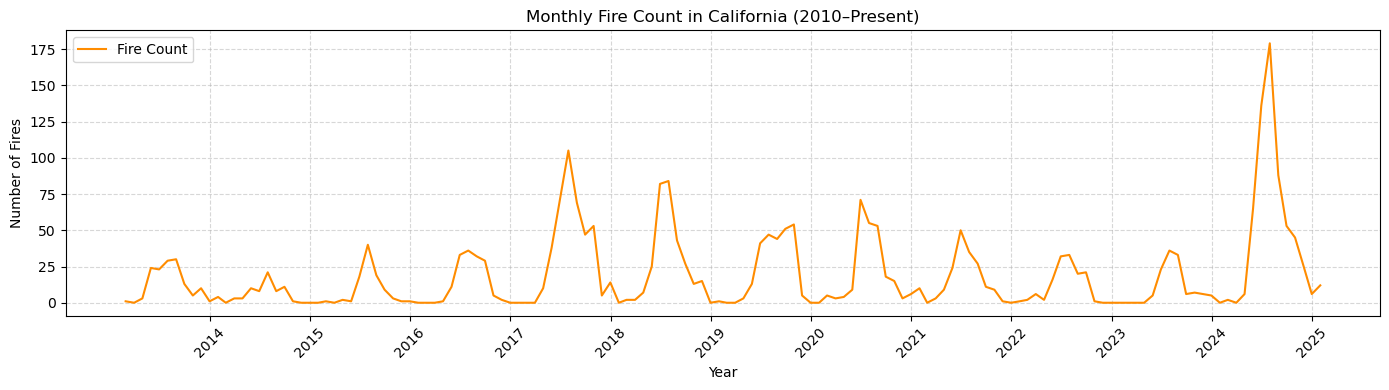

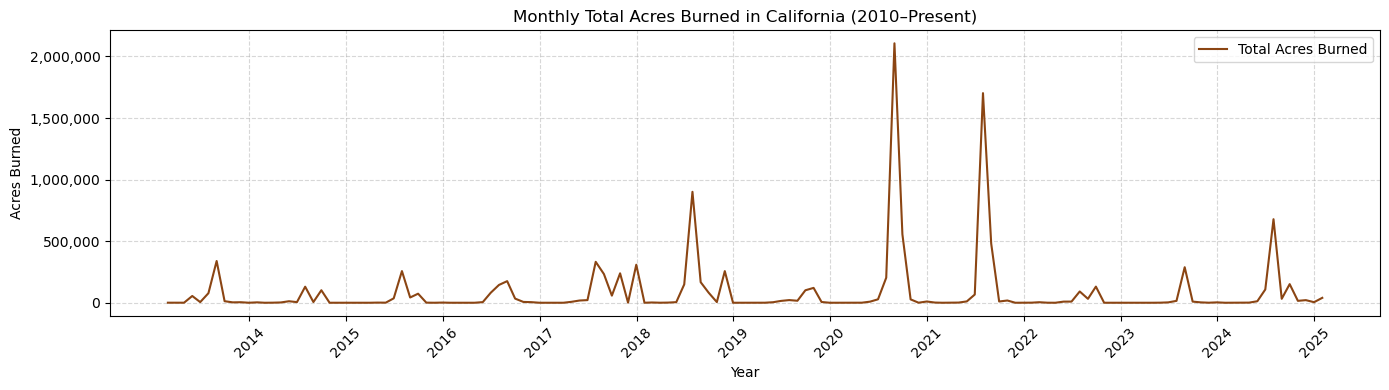

In [112]:
# Group by month and compute fire count and total acres burned
monthly = df_cleaned_final.groupby(pd.Grouper(key='fire_dateonly_created', freq='M')).agg({
    'fire_acres_burned': 'sum',
    'fire_dateonly_created': 'count'
}).rename(columns={'fire_dateonly_created': 'fire_count'})

# Fire Count Plot
plt.figure(figsize=(14, 4))
plt.plot(monthly.index, monthly['fire_count'], color='darkorange', label='Fire Count')
plt.title("Monthly Fire Count in California (2010–Present)")
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.xticks(pd.date_range(start=monthly.index.min(), end=monthly.index.max(), freq='YS'),
           labels=[str(d.year) for d in pd.date_range(start=monthly.index.min(), end=monthly.index.max(), freq='YS')],
           rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Acres Burned Plot
plt.figure(figsize=(14, 4))
plt.plot(monthly.index, monthly['fire_acres_burned'], color='saddlebrown', label='Total Acres Burned')
plt.title("Monthly Total Acres Burned in California (2010–Present)")
plt.xlabel("Year")
plt.ylabel("Acres Burned")
plt.xticks(pd.date_range(start=monthly.index.min(), end=monthly.index.max(), freq='YS'),
           labels=[str(d.year) for d in pd.date_range(start=monthly.index.min(), end=monthly.index.max(), freq='YS')],
           rotation=45)
# Format y-axis with commas instead of scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Monthly Fire Count (Top Plot)

- **Seasonality is clear and recurring**: fire activity peaks consistently between **late summer and early fall** (typically August–October).
- Notable **fire count spikes** occurred around:
  - Late **2017**
  - Mid **2018**
  - **2020**
  - **2024**
- The highest peak is seen in **2024**, exceeding **175 fires** in a single month, likely driven by extreme weather or reporting surges.
- Between peaks, fire activity drops significantly, often approaching **zero** in winter months.

---

### Monthly Total Acres Burned (Bottom Plot)

- Acreage burned shows **fewer but more dramatic spikes**, indicating the presence of **large, high-impact fires**.
- Massive fire months occurred in:
  - **Mid-2018**
  - **Late 2020** – the highest burn month (>2 million acres)
  - **Mid-2021**
  - Smaller spikes in **2024**
- The **disconnect between frequency and scale** is notable — months with **fewer fires** can still result in **massive total damage**, suggesting the role of **megafires**.

---

### Insights & Implications

- Wildfire activity in California is **strongly seasonal** and likely influenced by **climate conditions** (e.g., droughts, heat waves).
- **A few months drive the majority of acreage loss**, reinforcing the importance of rapid containment in peak fire season.
- Mitigation and response strategies should focus on the **late summer–fall window**, especially in years showing upward climate pressure.


  File "C:\Users\swath\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\swath\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\swath\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\swath\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


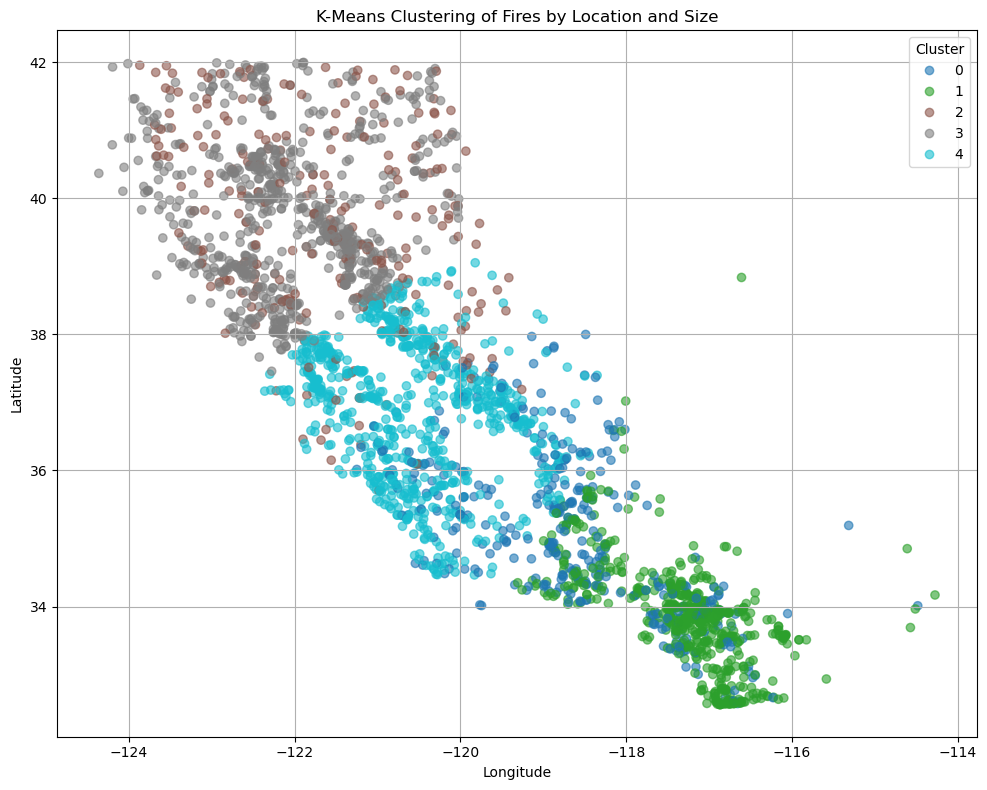

In [114]:
df_cluster = df_cleaned_final[['fire_latitude', 'fire_longitude', 'fire_acres_burned']]

# Log-transform acres burned to reduce skew
df_cluster['log_acres_burned'] = np.log1p(df_cluster['fire_acres_burned'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[['fire_latitude', 'fire_longitude', 'log_acres_burned']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_cluster['fire_longitude'], df_cluster['fire_latitude'],
                      c=df_cluster['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Fires by Location and Size')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.tight_layout()
plt.show()

## K-Means Clustering of Wildfires by Location and Size

This scatter plot shows the results of **K-Means clustering** applied to wildfire incidents in California, using **latitude, longitude**, and possibly **fire size** as clustering features. Each point represents a fire, and colors denote membership in one of **five clusters (0–4)**.

---

### Interpretation:

- **Cluster 3 (gray)** is primarily concentrated in **Northern California** (latitudes ~39°–42°), likely representing large forested regions with recurring fire activity.
- **Clusters 0 and 4 (light and bright blue)** form a **central diagonal band**, possibly capturing mid-sized or mid-elevation fires that stretch across the Sierra Nevada and into interior valleys.
- **Cluster 1 (green)** dominates **Southern California**, reflecting distinct fire behavior or terrain (e.g., chaparral, dry hillsides, or urban-wildland boundaries).
- **Cluster 2 (brown)** appears interspersed among other regions, possibly reflecting small or isolated fires that don’t strongly associate with specific geography.

---


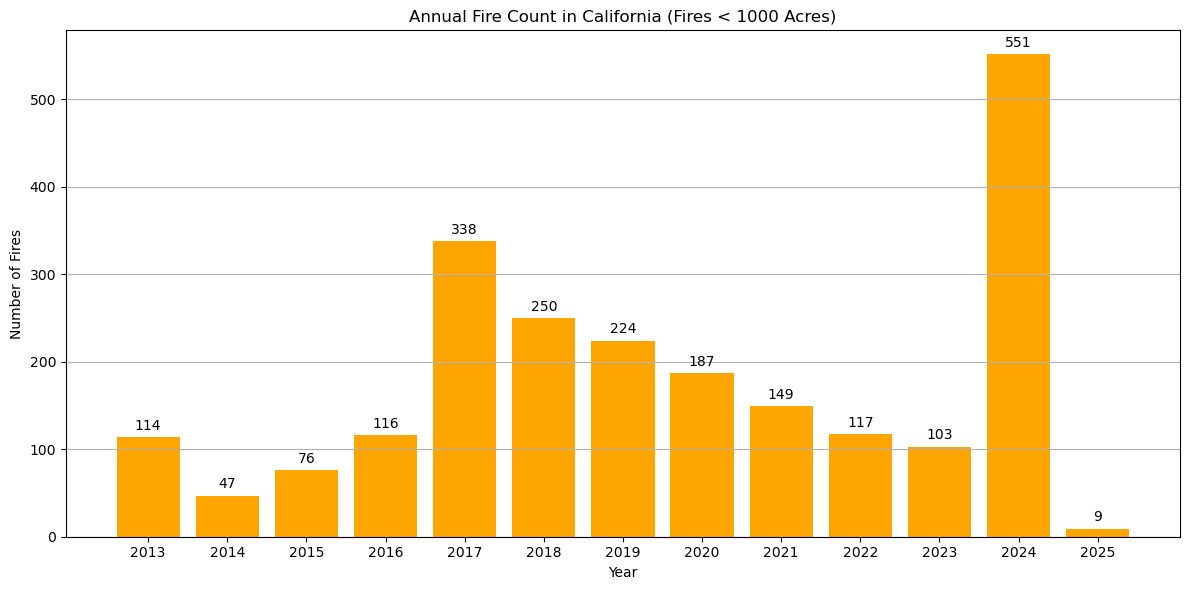

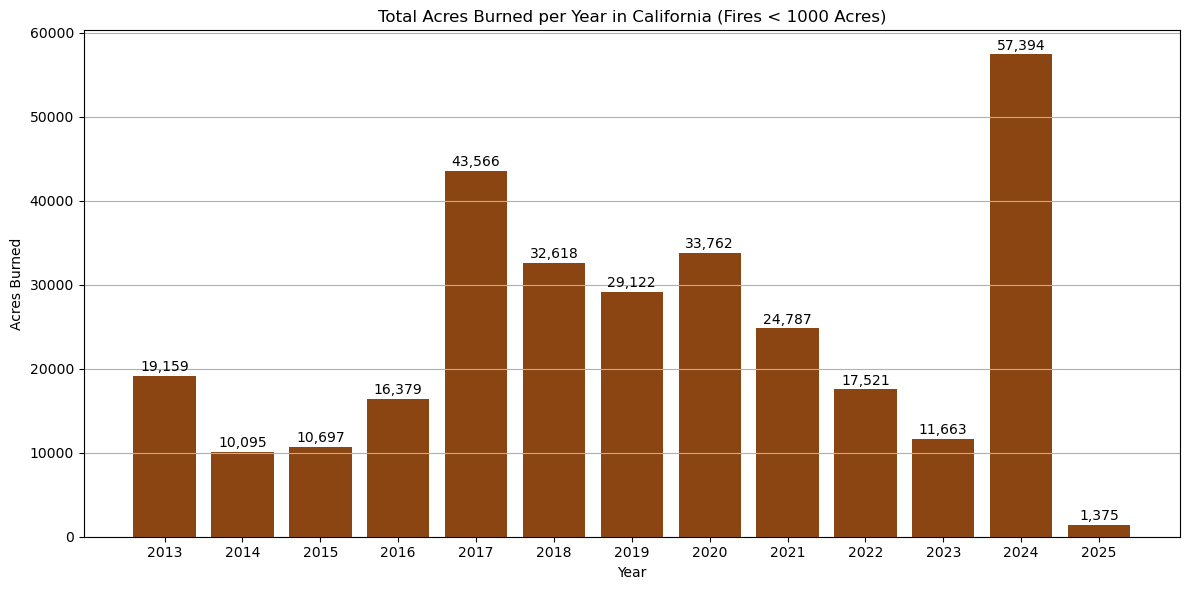

In [116]:

df = df_cleaned_final[df_cleaned_final["fire_acres_burned"] < 1000].copy()

# Aggregate: fire count and total acres burned per year
annual_stats = df.groupby("year").agg(
    fire_count=("fire_acres_burned", "count"),
    total_acres_burned=("fire_acres_burned", "sum")
).reset_index()

# bar plot for fire count with value labels
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats['year'], annual_stats['fire_count'], color='orange')
plt.title('Annual Fire Count in California (Fires < 1000 Acres)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y')
plt.xticks(annual_stats['year'])  # Ensure all years are shown

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# bar plot for total acres burned with value labels
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats['year'], annual_stats['total_acres_burned'], color='saddlebrown')
plt.title('Total Acres Burned per Year in California (Fires < 1000 Acres)')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.grid(axis='y')
plt.xticks(annual_stats['year'])  # Ensure all years are shown
plt.ticklabel_format(style='plain', axis='y')

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 200, f"{int(yval):,}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

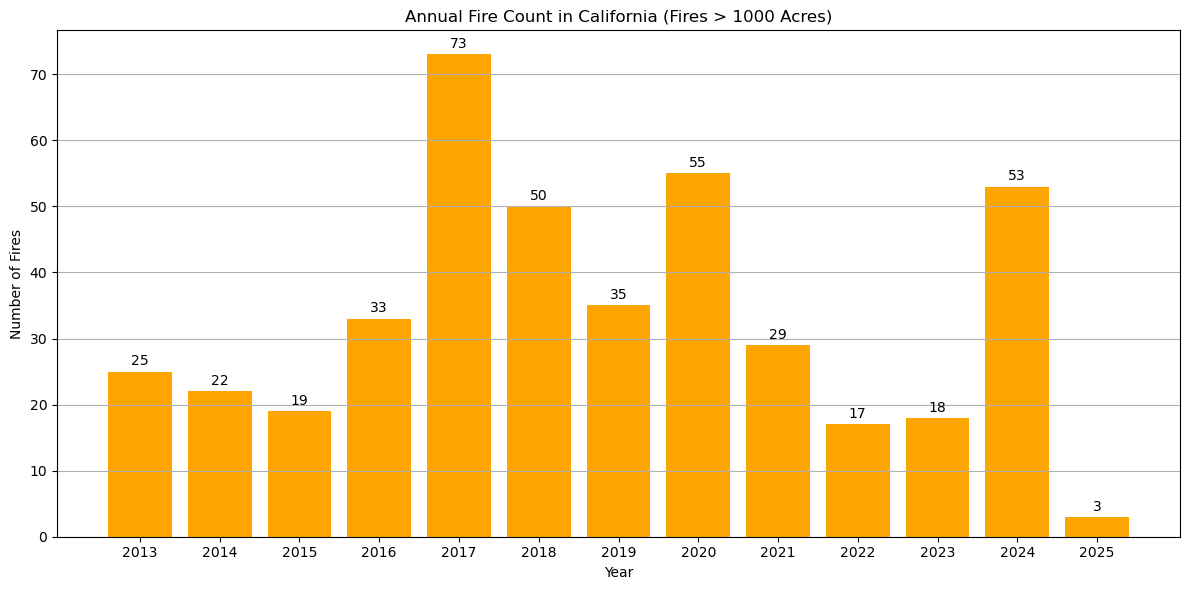

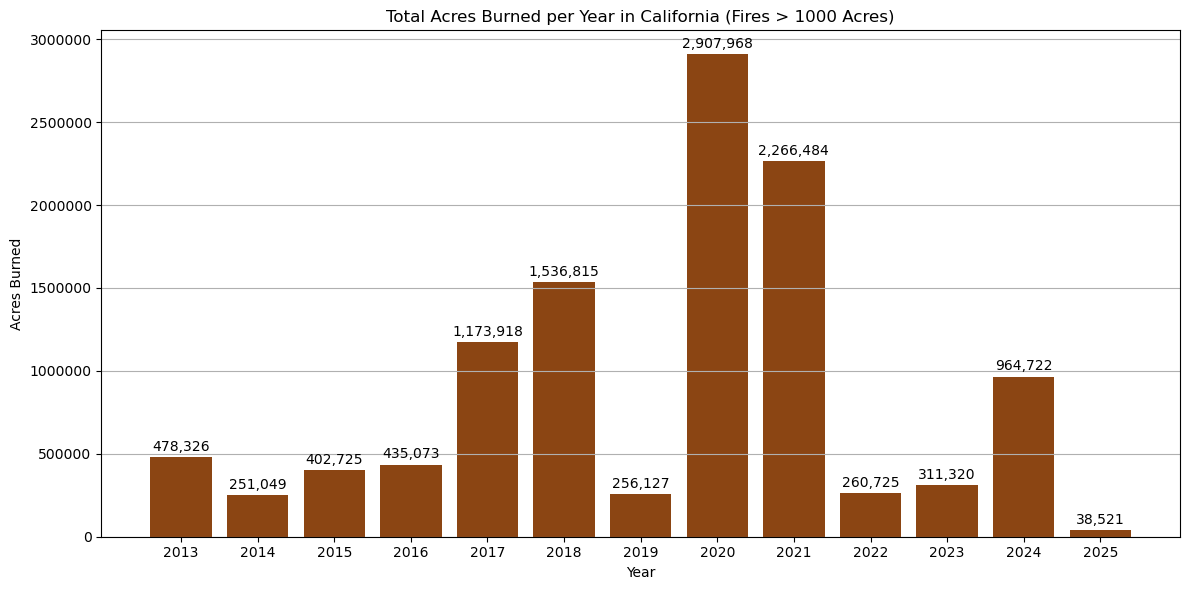

In [117]:
df = df_cleaned_final[df_cleaned_final["fire_acres_burned"] > 1000].copy()

# Aggregate: fire count and total acres burned per year
annual_stats_large = df.groupby("year").agg(
    fire_count=("fire_acres_burned", "count"),
    total_acres_burned=("fire_acres_burned", "sum")
).reset_index()

# Bar plot for fire count with values
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats_large['year'], annual_stats_large['fire_count'], color='orange')
plt.title('Annual Fire Count in California (Fires > 1000 Acres)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y')
plt.xticks(annual_stats_large['year'])

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Bar plot for total acres burned with values
plt.figure(figsize=(12, 6))
bars = plt.bar(annual_stats_large['year'], annual_stats_large['total_acres_burned'], color='saddlebrown')
plt.title('Total Acres Burned per Year in California (Fires > 1000 Acres)')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.grid(axis='y')
plt.xticks(annual_stats_large['year'])
plt.ticklabel_format(style='plain', axis='y')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20000, f"{int(yval):,}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [118]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   fire_name              2717 non-null   object        
 1   fire_dateonly_created  2717 non-null   datetime64[ns]
 2   precipitation          2717 non-null   float64       
 3   max_temp               2717 non-null   float64       
 4   min_temp               2717 non-null   float64       
 5   avg_wind_speed         2717 non-null   float64       
 6   temp_range             2717 non-null   float64       
 7   wind_temp_ratio        2717 non-null   float64       
 8   lagged_precipitation   2717 non-null   float64       
 9   lagged_avg_wind_speed  2717 non-null   float64       
 10  month                  2717 non-null   int64         
 11  season                 2717 non-null   object        
 12  fire_longitude         2717 non-null   float64       
 13  fir

In [119]:
df_cleaned_final.shape

(2717, 20)

In [120]:
df_cleaned_final.to_csv('../data/cleaned.csv', index=False)